In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# df = pd.read_csv('processed_data/data.csv')
df = pd.read_csv('processed_data/combined_boxscores.csv')
df = df.sort_values('game_day').reset_index(drop=True)
exclude_cols = ['pts_home','pts_away','game_id', 'team','team_home','home_team','team_away','away_team', 'game_day','other_team_score','score_other','score','target']
stat_cols = ['fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'to', 'pf']
cumul_cols = [x for x in df.columns if 'cumul' in x]
test_removal = ['home_rank','away_rank','is_home']
df = df.dropna()


In [306]:
# df = df[df['is_home']==1]

In [339]:
df.shape

(5111, 48)

In [309]:
df['pts_home'].describe()

count    5111.000000
mean       75.287224
std        12.108320
min         0.000000
25%        67.000000
50%        75.000000
75%        83.000000
max       134.000000
Name: pts_home, dtype: float64

<AxesSubplot: xlabel='pts_home', ylabel='Count'>

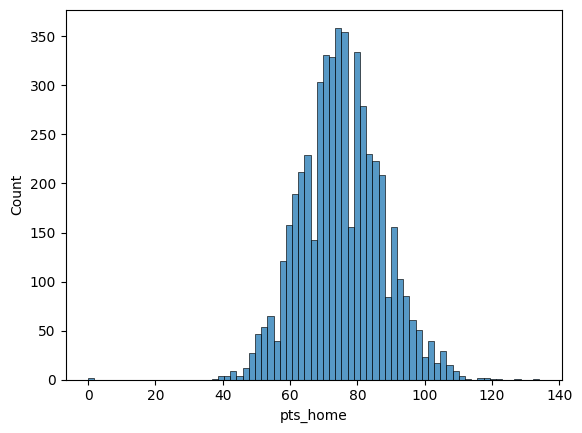

In [387]:
sns.histplot(df['pts_home'])

<AxesSubplot: xlabel='pts_away', ylabel='Count'>

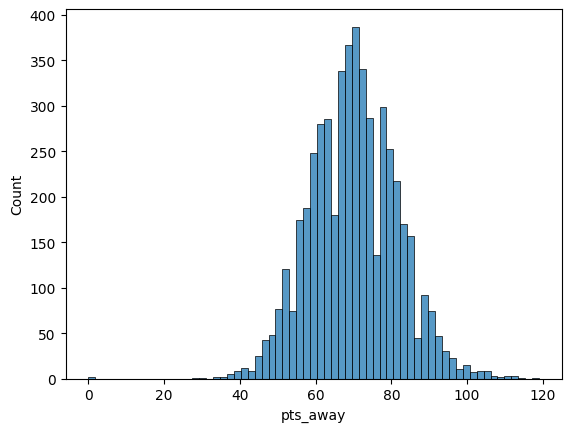

In [503]:
sns.histplot(df['pts_away'])

In [3]:
df = df[(df['pts_home']>=40) & (df['pts_home']<=110) & (df['pts_away']>=37) & (df['pts_away']<=105)]

<AxesSubplot: xlabel='pts_home', ylabel='Count'>

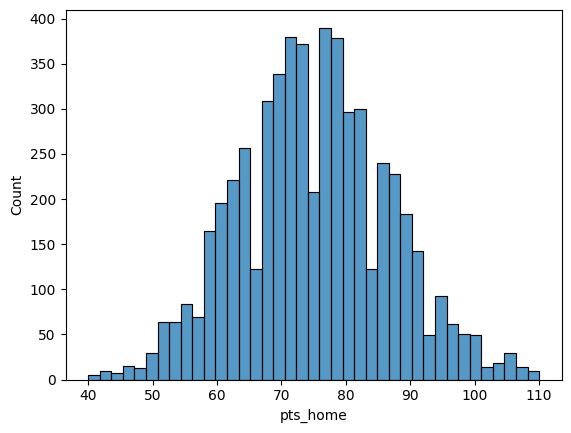

In [4]:
sns.histplot(df['pts_home'])

<AxesSubplot: xlabel='pts_away', ylabel='Count'>

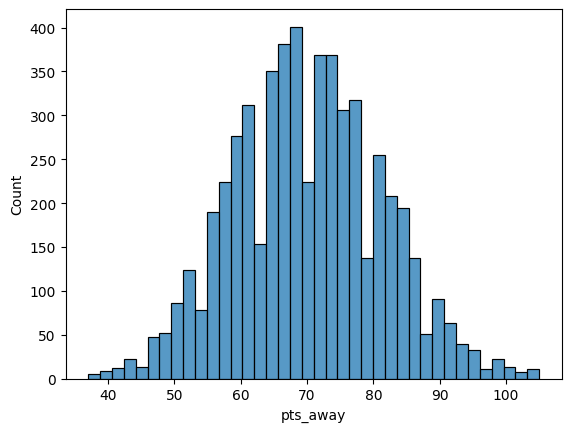

In [5]:
sns.histplot(df['pts_away'])

In [507]:
# home_rr = RidgeClassifier(alpha=1)
# away_rr = RidgeClassifier(alpha=1)
# split=TimeSeriesSplit(n_splits=3)

# home_sfs= SequentialFeatureSelector(home_rr, n_features_to_select=25, direction='forward', cv=split)
# away_sfs= SequentialFeatureSelector(away_rr, n_features_to_select=25, direction='forward', cv=split)

In [6]:
feature_cols = df.columns[~df.columns.isin(exclude_cols+test_removal+cumul_cols)]
home_target_col = 'pts_home'
away_target_col = 'pts_away'

In [622]:
feature_cols

Index(['fgm_home', 'fga_home', '2pm_home', '2pa_home', '3pm_home', '3pa_home',
       'ftm_home', 'fta_home', 'oreb_home', 'dreb_home', 'reb_home',
       'ast_home', 'stl_home', 'blk_home', 'to_home', 'pf_home',
       'is_conference', 'is_neutral', 'homeTeam_wins', 'homeTeam_losses',
       'awayTeam_wins', 'awayTeam_losses', 'fgm_away', 'fga_away', '2pm_away',
       '2pa_away', '3pm_away', '3pa_away', 'ftm_away', 'fta_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'to_away',
       'pf_away'],
      dtype='object')

In [7]:
def backtest(df, target_col, model, predictors, start=2, step=1):
    all_predictions=[]
    unique_days=sorted(df['game_day'].unique())

    for i in range(start, len(unique_days), step):
        day = unique_days[i]
        train = df[df['game_day']<day]
        test = df[df['game_day']==day]

        model.fit(train[predictors], train[target_col])
        
        preds = model.predict(test[predictors]) 
        preds = pd.Series(preds, index=test.index)

        combined = pd.concat([test[target_col], preds], axis=1)
        combined.columns = ['actual','prediction']

        all_predictions.append(combined)
    return model, pd.concat(all_predictions)


In [8]:
def modelOptimizer(df, target_col, num_features=[20,23,26,29,32,35], num_splits=[3]):    
    
    best_model = None
    best_model_mae = 100
    best_r2 = 0
    best_features = []
    for num_feats in num_features:
        for num_split in num_splits:
            rr = RidgeClassifier(alpha=1)
            split=TimeSeriesSplit(n_splits=num_split)
            sfs= SequentialFeatureSelector(rr, n_features_to_select=num_feats, direction='forward', cv=num_split)
            # sfs gets features
            sfs.fit(df[feature_cols],df[target_col])
            predictors = list(feature_cols[sfs.get_support()])
            model, predictions = backtest(df, target_col, rr, predictors)
            mae = mean_absolute_error(predictions['actual'], predictions['prediction'])
            model_r2_score = r2_score(predictions['actual'],predictions['prediction'])
            if mae<best_model_mae:                
                best_model = model
                best_features = predictors
                best_r2 = model_r2_score
                best_model_mae = mae
    return best_model, best_features, best_r2, best_model_mae

In [9]:
away_model, away_features, away_r2, away_mae = modelOptimizer(df, away_target_col,num_features=[28])

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/s

In [595]:
home_model, home_features, home_r2, home_mae = modelOptimizer(df, home_target_col,num_features=[30])

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/lib/python3.10/s

In [596]:
away_r2,home_r2

(0.5881835781303859, 0.527415932274975)

In [597]:
def findCumulAvgs(team):
    rolling = team.expanding().mean()
    return rolling

In [598]:
game_info_df = pd.read_csv('raw_data/game_info_df.csv')
game_info_df = game_info_df.dropna(subset=['home_record','away_record'])


In [599]:
game_info_df.columns

Index(['game_id', 'home_team', 'home_id', 'home_rank', 'home_record',
       'home_score', 'away_team', 'away_id', 'away_rank', 'away_record',
       'away_score', 'home_win', 'num_ots', 'is_conference', 'is_neutral',
       'is_postseason', 'tournament', 'game_day', 'game_time', 'game_loc',
       'arena', 'arena_capacity', 'attendance', 'tv_network', 'referee_1',
       'referee_2', 'referee_3'],
      dtype='object')

### Generate DataFrame to pull cumulative averages to use for next games predictions

In [600]:
exclude_boxscore_cols = ['player', 'player_id', 'position', 'starter', 'min']
boxscore_df = pd.read_csv('raw_data/boxscore_df.csv')

# Join into to get game info
boxscore_df = pd.merge(boxscore_df, game_info_df[['game_id','game_day','home_record','away_record']], on='game_id')
boxscores_filtered = boxscore_df[(boxscore_df.player_id == 'TOTAL')]
scaler = MinMaxScaler()
boxscores_filtered[stat_cols] = scaler.fit_transform(boxscores_filtered[stat_cols])
boxscores_filtered = boxscores_filtered.drop(exclude_boxscore_cols,axis=1).reset_index(drop=True)
boxscores_cumul_avgs = boxscores_filtered.groupby('team',group_keys=False)[stat_cols].apply(findCumulAvgs)
boxscores_final = pd.concat([boxscores_cumul_avgs, boxscores_filtered[['game_id','team','game_day','home_record','away_record']]], axis=1)

records_cols = ['home_record','away_record']
# Convert Record cols to Wins and Losses cols
for col in records_cols:
    team_type = col.split('_')[0]
    boxscores_final[col] = boxscores_final[col].astype(str)
    wins = boxscores_final.loc[:,col].apply(lambda x: x.split('-')[0])
    losses = boxscores_final.loc[:,col].apply(lambda x: x.split('-')[1])    
    boxscores_final[team_type+'Team_wins'] = wins
    boxscores_final[team_type+'Team_losses'] = losses
    boxscores_final = boxscores_final.drop(col,axis=1)
# lookup = pd.merge(boxscores_final, )

/var/folders/z_/b2p80qvn353dbq0c1vfq0q600000gq/T/ipykernel_6535/166461312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxscores_filtered[stat_cols] = scaler.fit_transform(boxscores_filtered[stat_cols])


### MARCH MADNESS SAVE

In [618]:
# FOR MARCH MADNESS
boxscores_final.to_csv('march_madness/boxscores_final_lookup.csv',index=False)

In [619]:
import pickle
with open('march_madness/march_madness_home_model.pkl','wb') as home_mdl_pkl:
    pickle.dump(home_model,home_mdl_pkl)

with open('march_madness/march_madness_away_model.pkl','wb') as away_mdl_pkl:
    pickle.dump(away_model,away_mdl_pkl)

In [621]:
away_features

['fga_home',
 '2pa_home',
 '3pm_home',
 '3pa_home',
 'ftm_home',
 'fta_home',
 'oreb_home',
 'dreb_home',
 'reb_home',
 'stl_home',
 'blk_home',
 'to_home',
 'pf_home',
 'homeTeam_losses',
 'fgm_away',
 'fga_away',
 '2pm_away',
 '2pa_away',
 '3pm_away',
 '3pa_away',
 'ftm_away',
 'oreb_away',
 'dreb_away',
 'reb_away',
 'ast_away',
 'stl_away',
 'blk_away',
 'pf_away']

# PREDICT

In [611]:
def predictOutcome(game_day, home_team_name, away_team_name,is_neutral=1, is_conference=0):
    game_date_str = game_day
    game_date = pd.to_datetime(game_date_str)
    boxscores_final['game_day'] = pd.to_datetime(boxscores_final['game_day'])
    home_most_recent_bs = pd.DataFrame(boxscores_final[(boxscores_final['team']==home_team_name) & (boxscores_final['game_day']<game_date)].iloc[-1,:]).transpose()
    away_most_recent_bs = pd.DataFrame(boxscores_final[(boxscores_final['team']==away_team_name) & (boxscores_final['game_day']<game_date)].iloc[-1,:]).transpose()

    home_team_cols_needed = {}
    for f in feature_cols:
        if '_home' in f:
            home_team_cols_needed[f.replace('_home','')]=f
    home_most_recent_bs=home_most_recent_bs.rename(columns=home_team_cols_needed)
    home_most_recent_bs=home_most_recent_bs.drop(['awayTeam_wins','awayTeam_losses'],axis=1)

    away_team_cols_needed = {}
    for f in feature_cols:
        if '_away' in f:
            away_team_cols_needed[f.replace('_away','')]=f
    away_most_recent_bs=away_most_recent_bs.rename(columns=away_team_cols_needed)
    away_most_recent_bs=away_most_recent_bs.drop(['homeTeam_wins','homeTeam_losses'],axis=1)

    home_most_recent_bs['join_helper']=1
    away_most_recent_bs['join_helper']=1

    validate_df = pd.merge(home_most_recent_bs, away_most_recent_bs,on='join_helper')
    validate_df['is_neutral']=is_neutral
    validate_df['is_conference']=is_conference

    home_pred = home_model.predict(validate_df[home_features]) 
    away_pred = away_model.predict(validate_df[away_features])
    print(home_team_name, home_pred[0])
    print(away_team_name, away_pred[0])
    winning_team = home_team_name if home_pred[0]>away_pred[0] else away_team_name
    return {'game_day':game_date_str,"winning_team": winning_team, home_team_name: home_pred[0], away_team_name: away_pred[0]}


In [615]:
predictOutcome('2024-02-01','North Carolina Tar Heels','Duke Blue Devils')

North Carolina Tar Heels 90
Duke Blue Devils 79


{'game_day': '2024-02-01',
 'winning_team': 'North Carolina Tar Heels',
 'North Carolina Tar Heels': 90,
 'Duke Blue Devils': 79}

In [564]:
game_date_str = '2024-03-06'
game_date = pd.to_datetime(game_date_str)
boxscores_final['game_day'] = pd.to_datetime(boxscores_final['game_day'])
# home_team_name ='Duke Blue Devils'
home_team_name = 'Seton Hall Pirates'
# away_team_name = 'Boston College Eagles'
away_team_name = 'Villanova Wildcats'
home_most_recent_bs = pd.DataFrame(boxscores_final[(boxscores_final['team']==home_team_name) & (boxscores_final['game_day']<game_date)].iloc[-1,:]).transpose()
away_most_recent_bs = pd.DataFrame(boxscores_final[(boxscores_final['team']==away_team_name) & (boxscores_final['game_day']<game_date)].iloc[-1,:]).transpose()



In [565]:
home_team_cols_needed = {}
for f in feature_cols:
    if '_home' in f:
        home_team_cols_needed[f.replace('_home','')]=f
home_most_recent_bs=home_most_recent_bs.rename(columns=home_team_cols_needed)
home_most_recent_bs=home_most_recent_bs.drop(['awayTeam_wins','awayTeam_losses'],axis=1)

away_team_cols_needed = {}
for f in feature_cols:
    if '_away' in f:
        away_team_cols_needed[f.replace('_away','')]=f
away_most_recent_bs=away_most_recent_bs.rename(columns=away_team_cols_needed)
away_most_recent_bs=away_most_recent_bs.drop(['homeTeam_wins','homeTeam_losses'],axis=1)

home_most_recent_bs['join_helper']=1
away_most_recent_bs['join_helper']=1

validate_df = pd.merge(home_most_recent_bs, away_most_recent_bs,on='join_helper')
validate_df['is_neutral']=0
validate_df['is_conference']=1


In [553]:
validate_df

,fgm_home,fga_home,2pm_home,2pa_home,3pm_home,3pa_home,ftm_home,fta_home,oreb_home,dreb_home,...,blk_away,to_away,pf_away,game_id_y,team_y,game_day_y,awayTeam_wins,awayTeam_losses,is_neutral,is_conference
0,0.505305,0.610632,0.521552,0.574713,0.284936,0.351865,0.365517,0.370521,0.376176,0.514426,...,0.142241,0.316092,0.384483,401599556,Villanova Wildcats,2024-03-02,17,12,0,1


In [566]:
home_pred = home_model.predict(validate_df[home_features]) 
away_pred = away_model.predict(validate_df[away_features])


In [567]:
print('HOME:',home_pred[0])
print('AWAY:',away_pred[0])

HOME: 72
AWAY: 76


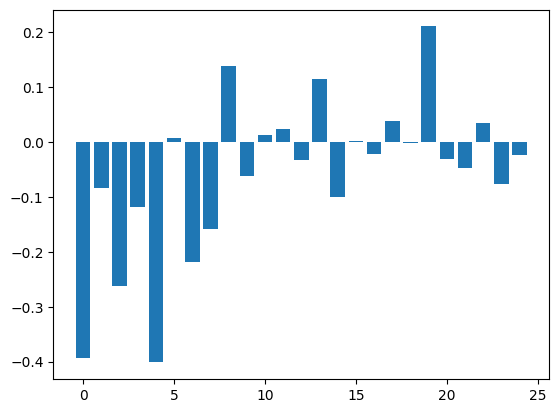

In [499]:
importance = home_model.coef_[0]
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [629]:
pd.DataFrame(data=list(boxscores_final['team'].unique()),columns=['team']).to_csv('march_madness/teams.csv',index=False)